In [32]:
import torch

In [27]:
!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [33]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [34]:
CSV_FILE = 'object-localization-dataset/train.csv'
DATA_DIR = 'object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 10
# MODEL_NAME = 'efficientnet_b0'
MODEL_NAME = 'efficientnet_b0'
NUM_COR = 4


In [35]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


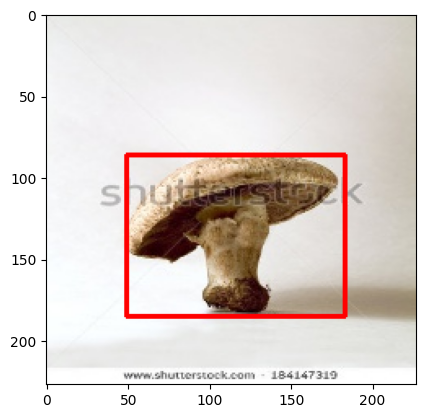

In [36]:
row = df.iloc[2]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [37]:
train_df, valid_df = train_test_split(df, test_size= 0.2, random_state=42)

In [38]:
import albumentations as A

In [39]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields=['class_labels']))

In [40]:
class ObjLocDataset(torch.utils.data.Dataset): 
    def __init__(self, df, augmentations = None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax

        bbox = [[xmin, ymin, xmax, ymax]]

        img_path = DATA_DIR + row.img_path

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2,0,1) / 255.0
        bbox = torch.Tensor(bbox)

        return img, bbox


In [41]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)


In [42]:
print(f"Total examples in the trainset : {len(trainset)}")
print(f"Total examples in the validset : {len(validset)}")

Total examples in the trainset : 148
Total examples in the validset : 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


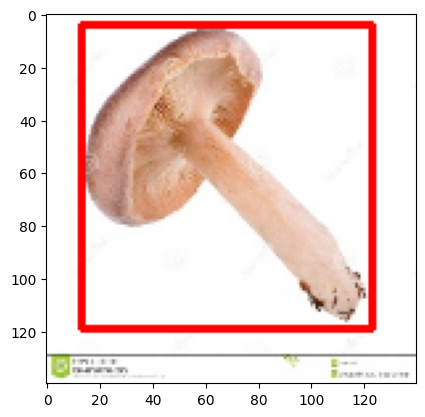

In [43]:
img, bbox = trainset[120]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

In [44]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)


In [45]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [46]:
for images, bboxes in trainloader:
    break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


In [47]:
from torch import nn 
import timm

timm.list_models()

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw

In [48]:
class ObjLocModel(nn.Module):
    def __init__(self, model_name):
        super(ObjLocModel, self).__init__()

        self.backbone = timm.create_model(model_name, pretrained = False, num_classes = 4)

    def forward(self, images, gt_bboxes = None):

        bboxes = self.backbone(images)

        if gt_bboxes != None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss

        return bboxes


In [49]:
model = ObjLocModel(MODEL_NAME)
model.to(DEVICE);

In [50]:
random_img = torch.rand(1,3, 140, 140).to(DEVICE)

model(random_img).shape

torch.Size([1, 4])

In [51]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train() # Dropout ON

#     for data in tqdm(dataloader):
    for data in dataloader:

        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    return total_loss / len(dataloader)

In [52]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for data in tqdm(dataloader):
            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)

            total_loss += loss.item()

        return total_loss / len(dataloader)

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [54]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print(' WEIGHTS-ARE-SAVES')

        best_valid_loss = valid_loss

    print(f'Epoch: {i + 1} train loss: {train_loss} valid loss: {valid_loss}')

  0%|          | 0/3 [00:00<?, ?it/s]

 WEIGHTS-ARE-SAVES
Epoch: 1 train loss: 7220.399755859375 valid loss: 6693.493815104167


  0%|          | 0/3 [00:00<?, ?it/s]

 WEIGHTS-ARE-SAVES
Epoch: 2 train loss: 5976.56474609375 valid loss: 3902.1826985677085


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3 train loss: 5118.168359375 valid loss: 4250.8642578125


  0%|          | 0/3 [00:00<?, ?it/s]

 WEIGHTS-ARE-SAVES
Epoch: 4 train loss: 4643.783056640625 valid loss: 3613.0369466145835


  0%|          | 0/3 [00:00<?, ?it/s]

 WEIGHTS-ARE-SAVES
Epoch: 5 train loss: 4042.655029296875 valid loss: 2952.13916015625


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6 train loss: 3649.6919677734377 valid loss: 3510.3116861979165


  0%|          | 0/3 [00:00<?, ?it/s]

 WEIGHTS-ARE-SAVES
Epoch: 7 train loss: 3283.5394287109375 valid loss: 2576.3531901041665


  0%|          | 0/3 [00:00<?, ?it/s]

 WEIGHTS-ARE-SAVES
Epoch: 8 train loss: 2965.8474853515627 valid loss: 2316.6700032552085


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 train loss: 2582.672412109375 valid loss: 2439.8103841145835


  0%|          | 0/3 [00:00<?, ?it/s]

 WEIGHTS-ARE-SAVES
Epoch: 10 train loss: 2260.956921386719 valid loss: 2000.6624755859375


In [ ]:
import utils

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


with torch.no_grad():
    image, gt_bbox = validset[5] # (c, h, w)
    image = image.unsqueeze(0).to(DEVICE) # (bs, c, h, w)

    out_bbox = model(image)

    utils.compare_plots(image, gt_bbox, out_bbox)

In [57]:
valid_models = []
image_net_models =[]
for model_name in tqdm(timm.list_models()):
    model = timm.create_model(model_name, pretrained = False)
    try:
        if model.get_classifier().out_features == 1000:
            print(model_name)
            image_net_models.append(model_name)
    except Exception as ex:
        print(model_name)
        print(ex)

  0%|          | 0/964 [00:00<?, ?it/s]

adv_inception_v3
bat_resnext26ts
beit_base_patch16_224
beit_base_patch16_384
beit_large_patch16_224
beit_large_patch16_384
beit_large_patch16_512
beitv2_base_patch16_224
beitv2_large_patch16_224
botnet26t_256
botnet50ts_256
cait_m36_384
cait_m48_448
cait_s24_224
cait_s24_384
cait_s36_384
cait_xs24_384
cait_xxs24_224
cait_xxs24_384
cait_xxs36_224
cait_xxs36_384
coat_lite_mini
coat_lite_small
coat_lite_tiny
coat_mini
coat_tiny
coatnet_0_224
coatnet_0_rw_224
coatnet_1_224
coatnet_1_rw_224
coatnet_2_224
coatnet_2_rw_224
coatnet_3_224
coatnet_3_rw_224
coatnet_4_224
coatnet_5_224
coatnet_bn_0_rw_224
coatnet_nano_cc_224
coatnet_nano_rw_224
coatnet_pico_rw_224
coatnet_rmlp_0_rw_224
coatnet_rmlp_1_rw_224
coatnet_rmlp_2_rw_224
coatnet_rmlp_3_rw_224
coatnet_rmlp_nano_rw_224
coatnext_nano_rw_224
convit_base
convit_small
convit_tiny
convmixer_768_32
convmixer_1024_20_ks9_p14
convmixer_1536_20
convnext_atto
convnext_atto_ols
convnext_base
convnext_base_384_in22ft1k
convnext_base_in22ft1k
convnext_fe

maxxvit_rmlp_small_rw_256
maxxvit_rmlp_tiny_rw_256
mixer_b16_224
mixer_b16_224_miil
mixer_b32_224
mixer_l16_224
mixer_l32_224
mixer_s16_224
mixer_s32_224
mixnet_l
mixnet_m
mixnet_s
mixnet_xl
mixnet_xxl
mnasnet_050
mnasnet_075
mnasnet_100
mnasnet_140
mnasnet_a1
mnasnet_b1
mnasnet_small
mobilenetv2_035
mobilenetv2_050
mobilenetv2_075
mobilenetv2_100
mobilenetv2_110d
mobilenetv2_120d
mobilenetv2_140
mobilenetv3_large_075
mobilenetv3_large_100
mobilenetv3_large_100_miil
mobilenetv3_rw
mobilenetv3_small_050
mobilenetv3_small_075
mobilenetv3_small_100
mobilevit_s
mobilevit_xs
mobilevit_xxs
mobilevitv2_050
mobilevitv2_075
mobilevitv2_100
mobilevitv2_125
mobilevitv2_150
mobilevitv2_150_384_in22ft1k
mobilevitv2_150_in22ft1k
mobilevitv2_175
mobilevitv2_175_384_in22ft1k
mobilevitv2_175_in22ft1k
mobilevitv2_200
mobilevitv2_200_384_in22ft1k
mobilevitv2_200_in22ft1k
mvitv2_base
mvitv2_large
mvitv2_small
mvitv2_small_cls
mvitv2_tiny
nasnetalarge
nest_base
nest_small
nest_tiny
nf_ecaresnet26
nf_ecares

tresnet_m
tresnet_m_448
tresnet_v2_l
tresnet_xl
tresnet_xl_448
tv_densenet121
tv_resnet34
tv_resnet50
tv_resnet101
tv_resnet152
tv_resnext50_32x4d
twins_pcpvt_base
twins_pcpvt_large
twins_pcpvt_small
twins_svt_base
twins_svt_large
twins_svt_small
vgg11
vgg11_bn
vgg13
vgg13_bn
vgg16
vgg16_bn
vgg19
vgg19_bn
visformer_small
visformer_tiny
vit_base_patch8_224
vit_base_patch8_224_dino
'Identity' object has no attribute 'out_features'
vit_base_patch16_18x2_224
vit_base_patch16_224
vit_base_patch16_224_dino
'Identity' object has no attribute 'out_features'
vit_base_patch16_224_miil
vit_base_patch16_224_sam
vit_base_patch16_384
vit_base_patch16_plus_240
vit_base_patch16_rpn_224
vit_base_patch32_224
vit_base_patch32_224_sam
vit_base_patch32_384
vit_base_patch32_plus_256
vit_base_r26_s32_224
vit_base_r50_s16_224
vit_base_r50_s16_384
vit_base_resnet26d_224
vit_base_resnet50_384
vit_base_resnet50d_224
vit_giant_patch14_224
vit_gigantic_patch14_224
vit_huge_patch14_224
vit_large_patch14_224
vit_lar

In [26]:
model = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

In [221]:
a,b,c = model.default_cfg["input_size"]
input_data = torch.randn(1,a,b,c)

In [225]:
model(input_data).shape[1]

4

In [27]:
model.get_classifier()

Linear(in_features=1280, out_features=4, bias=True)

In [28]:
model.get_classifier().out_features

4